# Описание проекта <a id="шаг_1"></a>

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

#### Описание данных
Данные геологоразведки трёх регионов находятся в файлах: 1 регион -geo_data_0.csv; 2 регион - geo_data_1.csv; 3 регион - geo_data_2.csv.  

id — уникальный идентификатор скважины;  
f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);  
product — объём запасов в скважине (тыс. баррелей).  

#### Условия задачи:

Использовать модель линейной регрессии (остальные — недостаточно предсказуемые).
Исследовать 500 точек при геологоразведке, выбрать 200 с наибольшими запасами для расчёта прибыли.
Бюджет на разработку скважин в регионе — 10 млрд рублей.
Стоимость одного барреля нефти 450 рублей. Объём указан в 1000 баррелей.
Выбрать регионы, в которых вероятность убытков меньше 2.5%. Среди регионов, прошедших оценку рисков, выбрать один с наибольшей средней прибылью.  

#### План выполнения работы:
[1.Описание проекта](#шаг_1) 
[2.Загрузка и подготовка данных](#шаг_2)    
[3.Обучение и проверка модели](#шаг_3)   
[4.Подготовка к расчёту прибыли](#шаг_4)   
[5.Расчёт прибыли и рисков](#шаг_5)     


# Загрузка и подготовка данных <a id="шаг_1"></a>

Импорт библиотек

In [1]:
import pandas as pd
import numpy as np  

import matplotlib.pyplot as plt
plt.style.use('ggplot')  

import warnings
warnings.filterwarnings('ignore')  
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
data0 = pd.read_csv('/datasets/geo_data_0.csv')
data1 = pd.read_csv('/datasets/geo_data_1.csv')
data2 = pd.read_csv('/datasets/geo_data_2.csv')

Смотрим на данные

In [3]:
data0.info()
data0.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [4]:
data0.duplicated().sum()

0

In [5]:
data1.info()
data1.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [6]:
data1.duplicated().sum()

0

In [7]:
data2.info()
data2.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [8]:
data2.duplicated().sum()

0

Пропусков и дубликатов нет.  
Визуализируем распределения.

**Регион 1**

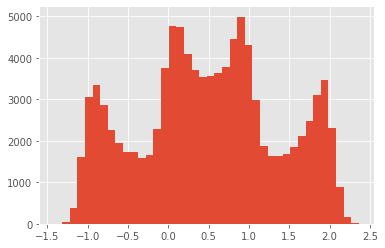

In [9]:
data0['f0'].hist(bins=40)


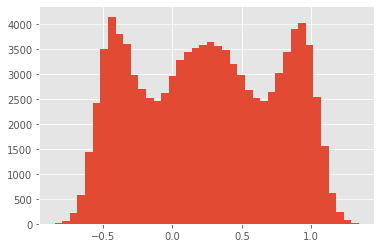

In [10]:
data0['f1'].hist(bins=40)

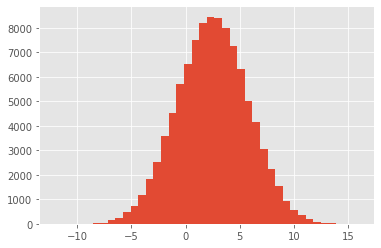

In [11]:
data0['f2'].hist(bins=40)

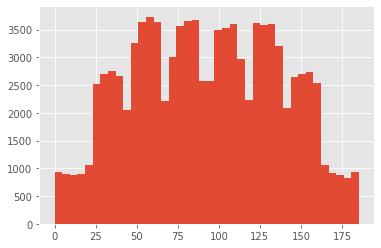

In [12]:
data0['product'].hist(bins=40)

**Регион 2**

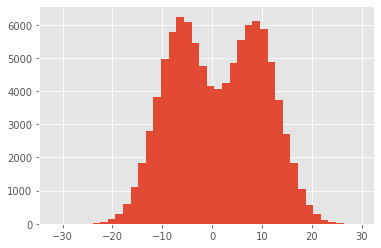

In [13]:
data1['f0'].hist(bins=40)

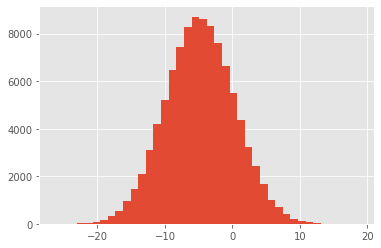

In [14]:
data1['f1'].hist(bins=40)

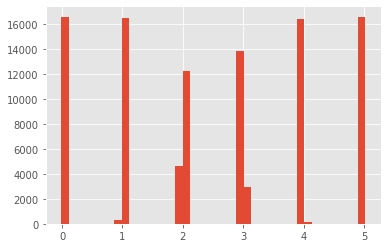

In [15]:
data1['f2'].hist(bins=40)

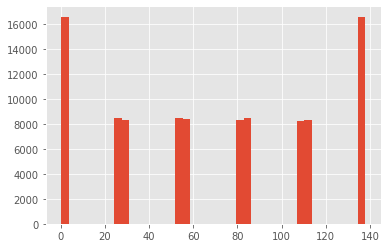

In [16]:
data1['product'].hist(bins=40)

**Регион 2**

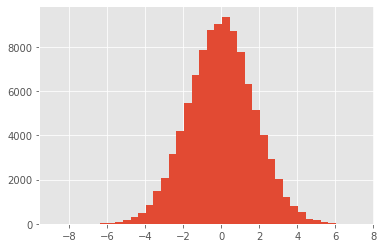

In [17]:
data2['f0'].hist(bins=40)

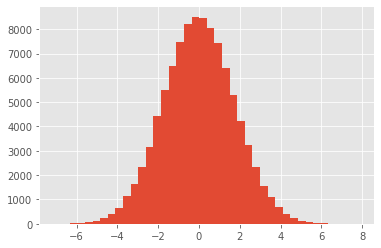

In [18]:
data2['f1'].hist(bins=40)

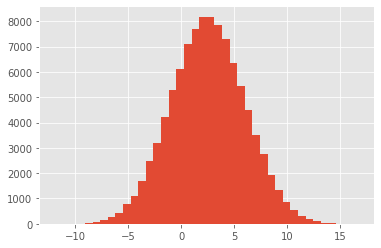

In [19]:
data2['f2'].hist(bins=40)

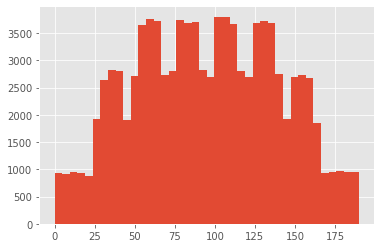

In [20]:
data2['product'].hist(bins=40)

Данные Региона 2, визуально, отличаются от двух других регионов. Так как неизвестно, что означают сами признаки, сложно оценить адекватность распределений и выбросов. Возможно, в дальнейшем выявим какие -то отличия в данных Региона 2.

Сроавним запасы нефти по всем трем регионам

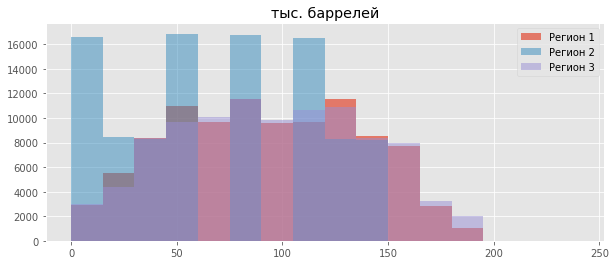

Средние запасы, тыс. баррелей:
Регион 1    92.5
Регион 2    68.8
Регион 3    95.0
dtype: float64


In [21]:
products = pd.DataFrame({'Регион 1': data0['product'], 'Регион 2': data1['product'], 'Регион 3': data2['product']})


bins = range(0,250,15)
products['Регион 1'].hist(bins=bins, alpha=0.7, label='Регион 1', figsize=(10,4))
products['Регион 2'].hist(bins=bins, alpha=0.5, label='Регион 2')
products['Регион 3'].hist(bins=bins, alpha=0.5, label='Регион 3')
plt.title('тыс. баррелей')
plt.legend()
plt.show()

print('Средние запасы, тыс. баррелей:')
print(products.mean().round(1))

2-й регион имеет значительно меньшие запасы нефти, чем 1-й и 3-й.

# Обучение и проверка модели <a id="шаг_3"></a>

По условиям задачи:  
Разделим данные на обучающую и валидационную выборки  
Используем модель линейной регрессии (согласно заданию)  
Выведем средний запас предсказанного сырья и RMSE модели 

In [22]:
# столбец id для обучения не нужен, и даже может мешать, его можно удалить
data0 = data0.drop(['id'], axis=1)
data1 = data1.drop(['id'], axis=1)
data2 = data2.drop(['id'], axis=1)

Выделим признаки и разделим данные на обучающую и валидационную выборки

In [23]:
data0_train, data0_valid = train_test_split(data0, test_size=0.25, random_state=12345)
data1_train, data1_valid = train_test_split(data1, test_size=0.25, random_state=12345)
data2_train, data2_valid = train_test_split(data2, test_size=0.25, random_state=12345)
print('Регион 1')
print('Кол-во строк в обучающей выборке:', data0_train.shape[0])
print('Кол-во строк в валидационной выборке:', data0_valid.shape[0])
print('')
print('Регион 2')
print('Кол-во строк в обучающей выборке:', data1_train.shape[0])
print('Кол-во строк в валидационной выборке:', data1_valid.shape[0])
print('')
print('Регион 3')
print('Кол-во строк в обучающей выборке:', data2_train.shape[0])
print('Кол-во строк в валидационной выборке:', data2_valid.shape[0])

Регион 1
Кол-во строк в обучающей выборке: 75000
Кол-во строк в валидационной выборке: 25000

Регион 2
Кол-во строк в обучающей выборке: 75000
Кол-во строк в валидационной выборке: 25000

Регион 3
Кол-во строк в обучающей выборке: 75000
Кол-во строк в валидационной выборке: 25000


In [24]:
# Выделяем признаки 
# Регион 1
features_train0 = data0_train.drop(['product'], axis=1)
target_train0 = data0_train['product']

features_valid0 = data0_valid.drop(['product'], axis=1)
target_valid0 = data0_valid['product']

# Регион 2
features_train1 = data1_train.drop(['product'], axis=1)
target_train1 = data1_train['product']

features_valid1 = data1_valid.drop(['product'], axis=1)
target_valid1 = data1_valid['product']

# Регион 3
features_train2 = data2_train.drop(['product'], axis=1)
target_train2 = data2_train['product']

features_valid2 = data2_valid.drop(['product'], axis=1)
target_valid2 = data2_valid['product']

Обучим модели

In [25]:
# Регион 1
model = LinearRegression()
model.fit(features_train0, target_train0)
predict0 = model.predict(features_valid0)
print('Фактический средний запас сырья:', target_valid0.mean())
print('Предположительный средний запас сырья:', predict0.mean())
print('Коэффициент детерминации:', r2_score(target_valid0, predict0))
print('RMSE:', np.sqrt(mean_squared_error(target_valid0, predict0)))

Фактический средний запас сырья: 92.07859674082927
Предположительный средний запас сырья: 92.59256778438038
Коэффициент детерминации: 0.27994321524487786
RMSE: 37.5794217150813


In [26]:
# Регион 2
model = LinearRegression()
model.fit(features_train1, target_train1)
predict1 = model.predict(features_valid1)
print('Фактический средний запас сырья:', target_valid1.mean())
print('Предположительный средний запас сырья:', predict1.mean())
print('Коэффициент детерминации:', r2_score(target_valid1, predict1))
print('RMSE:', np.sqrt(mean_squared_error(target_valid1, predict1)))

Фактический средний запас сырья: 68.72313602435997
Предположительный средний запас сырья: 68.728546895446
Коэффициент детерминации: 0.9996233978805127
RMSE: 0.893099286775616


In [27]:
# Регион 3
model = LinearRegression()
model.fit(features_train2, target_train2)
predict2 = model.predict(features_valid2)
print('Фактический средний запас сырья:', target_valid2.mean())
print('Предположительный средний запас сырья:', predict2.mean())
print('Коэффициент детерминации:', r2_score(target_valid2, predict2))
print('RMSE:', np.sqrt(mean_squared_error(target_valid2, predict2)))

Фактический средний запас сырья: 94.88423280885438
Предположительный средний запас сырья: 94.96504596800489
Коэффициент детерминации: 0.20524758386040443
RMSE: 40.02970873393434


* Наибольшие средние запасы в 1-м и 3-м регионе  
* С другой стороны модели 1-го и 3-го региона показали очень большую ошибку  37.5 и 51.80, а вот 2-й регион всего 0.9, но учитывая особенности распределения признаков в этом регионе, это скорее указывает на некоректные изначальные данные, чем на качество модели.

# Подготовка к расчёту прибыли <a id="шаг_4"></a>

**Данные задачи**  
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
Бюджет на разработку скважин в регионе — 10 млрд рублей.  
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.  
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.  

In [28]:
#запишем условия в переменные
bootstrap_size = 500 #При разведке исследуют 500 точек
total_budget = 10000000000
cost_one = 50000000
profit_per_barrel = 450 #Прибыль с одного барреля сырья 450 рублей
profit_per_product = 450000 #Доход с каждой единицы продукта 450 000 рублей, тысяча баррелей
risk = 0.025 # граница допустимого риска

bootstrap_length = 1000
n_profit = 200

In [29]:
min_product = cost_one // profit_per_product
print(f'Минимальный запас месторождения для окупаемости бурения скважины: {min_product} тыс.баррелей.')

Минимальный запас месторождения для окупаемости бурения скважины: 111 тыс.баррелей.


т.е. 111 тыс. баррелей является пороговым значением для окупаемости скважины. Данное значение превышает средние значения запасов скважин по всем регионам.   
По условиям задачи, бюджета нам хватит только на 200 скважин, по 50 млн. рублей на скважину.

In [30]:
# функция для расчета прибыли месторожения 
def profit_oil(predicted, target):    
    #target = pd.Series(target)
    target = target.reset_index(drop=True)
    #predicted = pd.Series(predicted)
    predicted = predicted.reset_index(drop=True)
    max_predicted = predicted.sort_values(ascending=False)[:200] 
    max_target = target[max_predicted.index]
    total_profit = max_target.sum() * profit_per_product
    profit = total_profit - total_budget        
    return profit        


# Расчёт прибыли и рисков  <a id="шаг_5"></a>

In [31]:
def bootstrap_profit(predicted, target):
    state = np.random.RandomState(12345)
    target = pd.Series(target)
    target = target.reset_index(drop=True)
    predicted = pd.Series(predicted)
    predicted = predicted.reset_index(drop=True)
    values = []
    for i in range(1000):
        target_subsample = target.sample(n=500, replace=True, random_state=state)
        predicted_subsample = predicted[target_subsample.index]
        subsample = (profit_oil(target_subsample, predicted_subsample))
        values.append(subsample)
        
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    mean = values.mean()
    risk = (values<0).mean()
       
    print("Нижняя граница доверительного интервала: {:,.2f} руб.".format(lower))
    print("Верхняя граница доверительного интервала: {:,.2f} руб.".format(upper))
    print("Средняя прибыль: {:,.2f} руб.".format(mean))
    print("Риск убытков: {:,.1%}.".format(risk)) 


In [32]:
print('Регион 1')
bootstrap_profit(target_valid0, predict0)
print('')
print('Регион 2')
bootstrap_profit(target_valid1, predict1)
print('')
print('Регион 3')
bootstrap_profit(target_valid2, predict2)

Регион 1
Нижняя граница доверительного интервала: -111,215,545.89 руб.
Верхняя граница доверительного интервала: 909,766,941.55 руб.
Средняя прибыль: 396,164,984.80 руб.
Риск убытков: 6.9%.

Регион 2
Нижняя граница доверительного интервала: 33,820,509.40 руб.
Верхняя граница доверительного интервала: 852,289,453.87 руб.
Средняя прибыль: 456,045,105.79 руб.
Риск убытков: 1.5%.

Регион 3
Нижняя граница доверительного интервала: -163,350,413.40 руб.
Верхняя граница доверительного интервала: 950,359,574.92 руб.
Средняя прибыль: 404,403,866.57 руб.
Риск убытков: 7.6%.


~~`Все три региона показывают нулевые риски. Самая высокая средняя прибыль 94 млрд. во 2-м Регионе, но 1-й регион с 95% вероятности получения 91 млрд. прибыли, выглядят более перспективными.`~~  

После изменений кода самым перспективным выглядит 2-й регион, но, я бы убедилась в корректности всех данных, т.к. слишком странные отличия от данных остальных регионов

# Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован